# Imports and reading data

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

DATA_FOLDER = "data"
PLOT_FOLDER = "plots"
CRM_PATH = os.path.join(DATA_FOLDER, "crm_data.csv")
WEB_TRACKING_PATH = os.path.join(DATA_FOLDER, "web_tracking.csv")

c:\Users\Finn Kopmann\Dokumente\Beruf und Finanzen\Fortbildung\data engineer\projects\case_study\case_study\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.mkdir(PLOT_FOLDER)

FileExistsError: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'plots'

In [4]:
crm_df = pd.read_csv(CRM_PATH)
web_tracking_df = pd.read_csv(WEB_TRACKING_PATH)

# EDA + Data validation

## CRM

In [5]:
crm_df.head()

,user_id,lead_status,company,sign_up_date,industry,country
0,137,Converted,Company_0,2024-03-09,Healthcare,US
1,163,Converted,Company_1,2024-03-01,Finance,UK
2,103,Prospect,Company_2,2024-03-02,Healthcare,France
3,163,Lost,Company_3,2024-03-01,SaaS,US
4,171,Lost,Company_4,2024-03-07,Healthcare,Germany


In [6]:
crm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       60 non-null     int64 
 1   lead_status   60 non-null     object
 2   company       60 non-null     object
 3   sign_up_date  60 non-null     object
 4   industry      60 non-null     object
 5   country       60 non-null     object
dtypes: int64(1), object(5)
memory usage: 2.9+ KB


In [7]:
crm_df.isna().sum()

user_id         0
lead_status     0
company         0
sign_up_date    0
industry        0
country         0
dtype: int64

In [8]:
crm_df.nunique()

user_id         47
lead_status      3
company         60
sign_up_date    11
industry         4
country          4
dtype: int64

**Warning:** user_id is not unique

Decide which users to keep based on latest sign_up_date.
Therefore transform sign_up_date to proper dimensions.

In [12]:
crm_df["sign_up_date"] = pd.to_datetime(crm_df["sign_up_date"])

In [13]:
crm_df.sort_values("sign_up_date", inplace=True)

In [14]:
crm_df.drop_duplicates(subset='user_id', keep="last", inplace=True)

In [15]:
crm_df["sign_up_date"].describe()

count                               47
mean     2024-03-06 07:39:34.468084992
min                2024-03-01 00:00:00
25%                2024-03-03 00:00:00
50%                2024-03-07 00:00:00
75%                2024-03-09 12:00:00
max                2024-03-11 00:00:00
Name: sign_up_date, dtype: object

In [16]:
crm_df[crm_df.user_id.duplicated()] 

,user_id,lead_status,company,sign_up_date,industry,country


#### Calculate Conversion Rate

In [18]:
print(f'Conversion Rate = {(crm_df["lead_status"] == "Converted").sum() / len(crm_df)}')

Conversion Rate = 0.425531914893617


### Distributions

In [19]:
def plot_column_distribution(df, col_name, output_path=None):
    counts = df[col_name].value_counts()
    print(counts)

    fig, ax = plt.subplots()
    counts.plot(kind="bar", ax=ax)

    ax.set_xlabel(col_name)
    ax.set_ylabel("Count")
    ax.set_title(f"Distribution of {col_name}")

    ax.grid(axis="y", linestyle="--")

    plt.tight_layout()

    if output_path:
        plt.savefig(os.path.join(PLOT_FOLDER, output_path), format="png")
        # plt.close()

    return ax

lead_status
Converted    20
Lost         15
Prospect     12
Name: count, dtype: int64


<Axes: title={'center': 'Distribution of lead_status'}, xlabel='lead_status', ylabel='Count'>

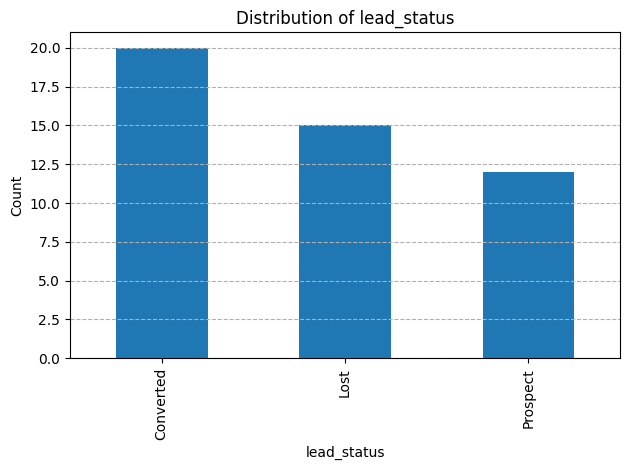

In [20]:
plot_column_distribution(crm_df, "lead_status", "lead_status_distribution.png")

industry
Finance       15
E-commerce    14
SaaS          12
Healthcare     6
Name: count, dtype: int64


<Axes: title={'center': 'Distribution of industry'}, xlabel='industry', ylabel='Count'>

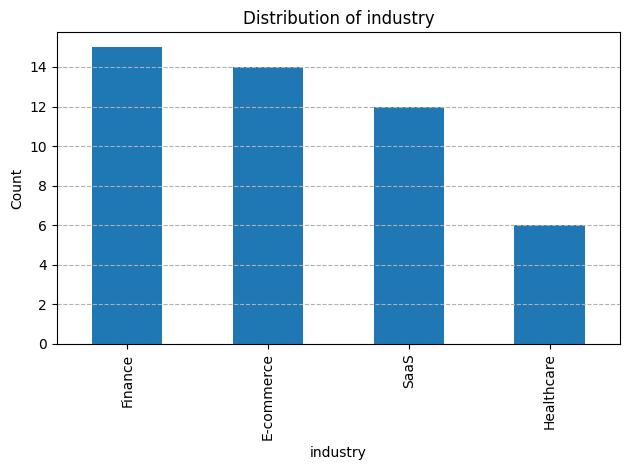

In [21]:
plot_column_distribution(crm_df, "industry", "industry_distribution.png")

country
US         23
UK         11
Germany    10
France      3
Name: count, dtype: int64


<Axes: title={'center': 'Distribution of country'}, xlabel='country', ylabel='Count'>

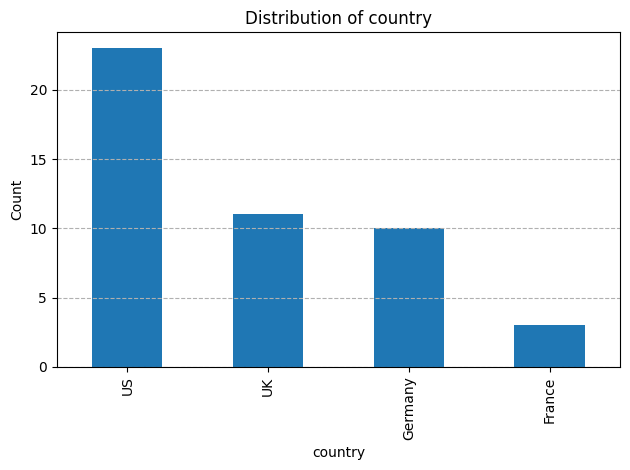

In [22]:
plot_column_distribution(crm_df, "country", "country_distribution.png")

- There are three options for lead_status: ("converted", "lost", "prospect")
- lead_status = "converted" is the most likely to appear with 25 incides (42%)
- The largest groups of web activity:
    - Industry: Finance (22)
    - Country: US (27)
- The smallest groups of web activity:
    - Industry: Healthcare (9)
    - Country: France (7) 

### Conversion rates

In [23]:
def get_conversion_rate(values, prospects = True):
    num_converted = values[values == "Converted"].shape[0]
    if prospects:
        total = values.shape[0]
    else:
        total = values[values != "Prospect"].shape[0]
    percentage = num_converted / total * 100
    return percentage

In [24]:
def plot_conversion_rate_by_column(df, col_name, prospects=True, output_path=None):
    conv_rate = df.groupby(col_name)["lead_status"].apply(lambda x: get_conversion_rate(x, prospects))
    sorted_conv_rates = conv_rate.sort_values(ascending=False)
    print(sorted_conv_rates)

    ax = sorted_conv_rates.plot(kind="bar")
    ax.set_xlabel(col_name)
    ax.set_ylabel("Conversion Rate")
    ax.set_title(f"Conversion Rate by {col_name}")
    ax.grid(axis="y", linestyle="--")

    plt.tight_layout()

    if output_path:
        plt.savefig(os.path.join(PLOT_FOLDER, output_path), format="png")
        # plt.close()
    
    return ax

country
US         56.521739
UK         36.363636
France     33.333333
Germany    20.000000
Name: lead_status, dtype: float64


<Axes: title={'center': 'Conversion Rate by country'}, xlabel='country', ylabel='Conversion Rate'>

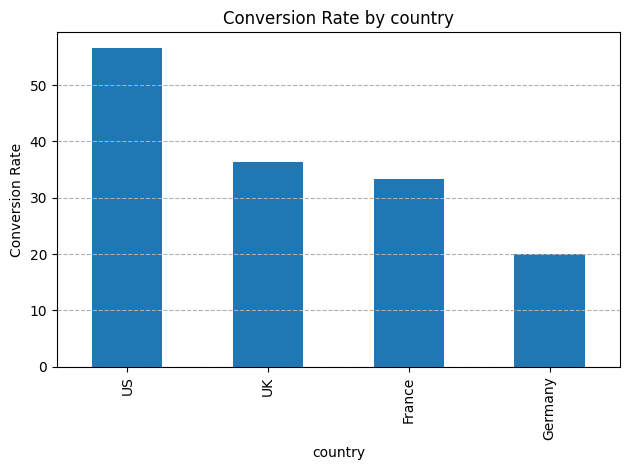

In [26]:
plot_conversion_rate_by_column(crm_df, "country", output_path="conversion_rate_by_country.png")

industry
Healthcare    83.333333
SaaS          41.666667
E-commerce    35.714286
Finance       33.333333
Name: lead_status, dtype: float64


<Axes: title={'center': 'Conversion Rate by industry'}, xlabel='industry', ylabel='Conversion Rate'>

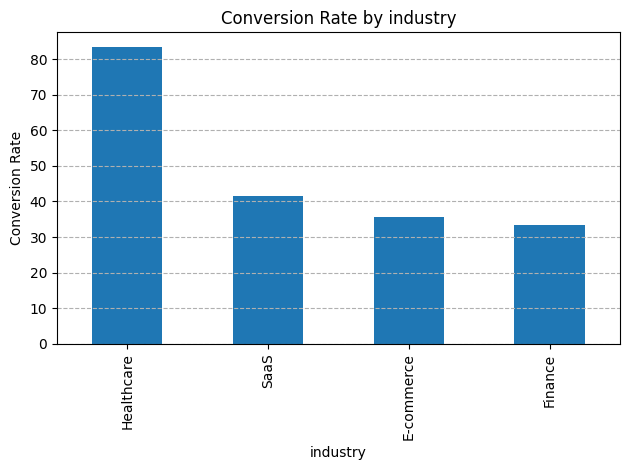

In [27]:
plot_conversion_rate_by_column(crm_df, "industry", output_path="conversion_rate_by_industry.png")

- The US has highest conversion rate (59%) in contrast to France with the lowest (14%)
- Healthcare has highest conversion rate (55%) in contrast to E-commerce (36%)
- **NOTE:** This conversion rate calculation also includes lead_status = "prospects"

industry
Healthcare    83.333333
SaaS          62.500000
E-commerce    50.000000
Finance       45.454545
Name: lead_status, dtype: float64


<Axes: title={'center': 'Conversion Rate by industry'}, xlabel='industry', ylabel='Conversion Rate'>

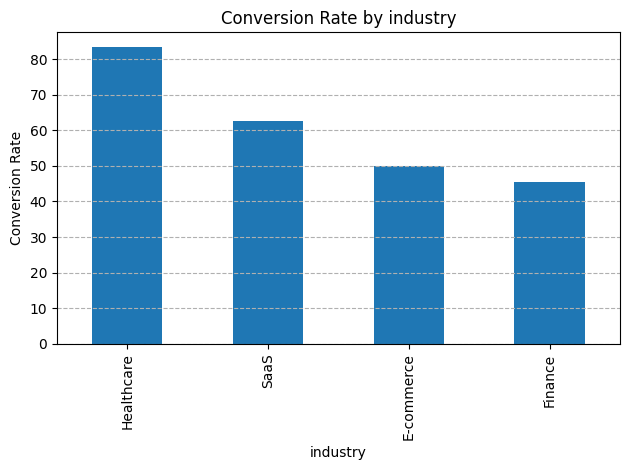

In [28]:
plot_conversion_rate_by_column(crm_df, "industry", False, "conversion_rate_by_industry_no_prospects.png")

country
US         68.421053
UK         57.142857
Germany    33.333333
France     33.333333
Name: lead_status, dtype: float64


<Axes: title={'center': 'Conversion Rate by country'}, xlabel='country', ylabel='Conversion Rate'>

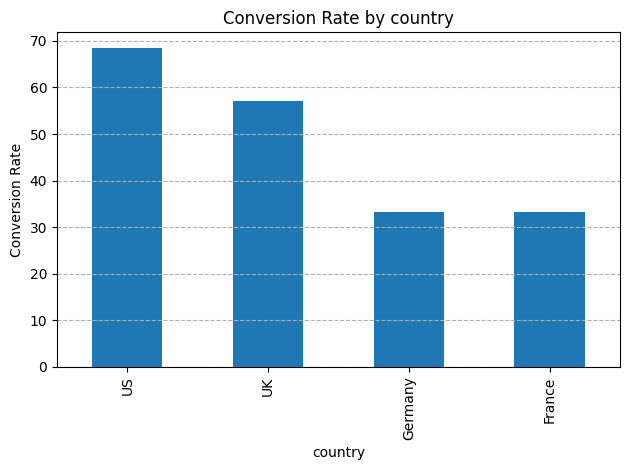

In [29]:
plot_conversion_rate_by_column(crm_df, "country",  False, "conversion_rate_by_country_no_prospects.png")

- findings change drastically by not including lead_status = "Prospect"
    - Industry: Conversion rate differences are less between industries (ranges from 51% (E-commerce) to 71% (Healthcare)
    - Country: The lowest country now is Germany with 25% and US with increased conversionrate of 69%

## Web Tracking Data

In [161]:
web_tracking_df.columns

Index(['user_id', 'session_id', 'timestamp', 'page', 'time_spent_sec',
       'utm_source', 'utm_medium', 'device_type'],
      dtype='object')

In [162]:
web_tracking_df.head()

,user_id,session_id,timestamp,page,time_spent_sec,utm_source,utm_medium,device_type
34,159,s034,2024-03-01 01:18:00,/features,90,google,organic,mobile
36,114,s036,2024-03-01 01:28:00,/contact,122,newsletter,cpc,mobile
90,171,s090,2024-03-01 01:45:00,/contact,217,google,referral,desktop
97,181,s097,2024-03-01 03:04:00,/contact,84,google,organic,mobile
82,133,s082,2024-03-01 04:29:00,/pricing,263,newsletter,cpc,mobile


In [163]:
web_tracking_df.nunique()

user_id            61
session_id        100
timestamp          99
page                4
time_spent_sec     74
utm_source          4
utm_medium          4
device_type         3
dtype: int64

In [164]:
web_tracking_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 34 to 39
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         100 non-null    int64         
 1   session_id      100 non-null    object        
 2   timestamp       100 non-null    datetime64[ns]
 3   page            100 non-null    object        
 4   time_spent_sec  100 non-null    int64         
 5   utm_source      100 non-null    object        
 6   utm_medium      100 non-null    object        
 7   device_type     100 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 11.1+ KB


In [165]:
web_tracking_df["timestamp"] = pd.to_datetime(web_tracking_df["timestamp"])

### Time spent

In [166]:
web_tracking_df.time_spent_sec.describe()

count    100.000000
mean     163.750000
std       71.941106
min       11.000000
25%      121.750000
50%      156.500000
75%      227.500000
max      295.000000
Name: time_spent_sec, dtype: float64

In [167]:
web_tracking_df.timestamp.describe()

count                              100
mean     2024-03-04 12:31:25.199999744
min                2024-03-01 01:18:00
25%                2024-03-02 18:32:15
50%                2024-03-04 16:09:30
75%                2024-03-06 04:45:15
max                2024-03-07 21:13:00
Name: timestamp, dtype: object

**NOTE:** Web tracking until 03-07, but users signed up until 03-10

In [168]:
def plot_time_spent_hist(df, time_col='time_spent_sec', output_path=None):
    ax = df[time_col].plot(kind="hist")

    ax.set_xlabel('Time Spent (seconds)')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of Time Spent')

    if output_path:
        plt.savefig(os.path.join(PLOT_FOLDER, output_path), format="png")
        # plt.close()

    return ax


<Axes: title={'center': 'Distribution of Time Spent'}, xlabel='Time Spent (seconds)', ylabel='Frequency'>

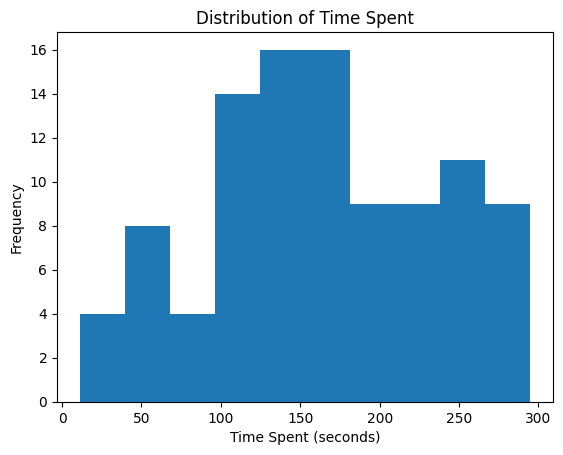

In [169]:
plot_time_spent_hist(df=web_tracking_df, output_path='hist.png')

In [170]:
web_tracking_df.time_spent_sec.describe()

count    100.000000
mean     163.750000
std       71.941106
min       11.000000
25%      121.750000
50%      156.500000
75%      227.500000
max      295.000000
Name: time_spent_sec, dtype: float64

### Missing users

In [171]:
web_tracking_df.nunique()

user_id            61
session_id        100
timestamp          99
page                4
time_spent_sec     74
utm_source          4
utm_medium          4
device_type         3
dtype: int64

**Warning:** Some users are missing in the crm

In [172]:
missing_users = set(web_tracking_df["user_id"]) - set(crm_df["user_id"])
len(missing_users)

14

**NOTE:** user_id {101, 105, 113, 129, 133, 135, 139, 148, 153, 172, 175, 179, 182, 186} have web tracking data but are missing for crm

In [173]:
web_tracking_df.isna().sum()

user_id           0
session_id        0
timestamp         0
page              0
time_spent_sec    0
utm_source        0
utm_medium        0
device_type       0
dtype: int64

### Time spent by columns

In [174]:
def get_mean_by_column(df, col, mean_over="time_spent_sec", plot=True):
    if mean_over:
        res = df.groupby(col)[mean_over].mean().sort_values(ascending=False)
        if plot:
            return res.plot(kind="bar")
        return res
    raise ValueError("mean_over must be specified")

In [175]:
web_tracking_df.columns

Index(['user_id', 'session_id', 'timestamp', 'page', 'time_spent_sec',
       'utm_source', 'utm_medium', 'device_type'],
      dtype='object')

In [176]:
get_mean_by_column(web_tracking_df, "page", plot=False)

page
/features    187.352941
/landing     172.357143
/pricing     139.666667
/contact     134.086957
Name: time_spent_sec, dtype: float64

<Axes: xlabel='page'>

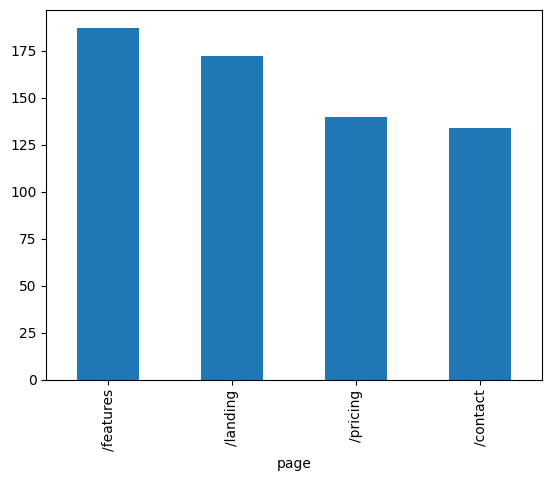

In [177]:
get_mean_by_column(web_tracking_df, "page", plot=True)

####Results
Users spend the most time inspecting features of the product.
--> check whether visiting /features is a indicator for conversion
Users do spend the least time on /contact and /pricing.
--> /contact makes sense, as they only get the contact and do not further interact
--> /pricing needs further investigation wether its a significant factor for conversion




In [178]:

get_mean_by_column(web_tracking_df, "utm_source", plot=False)

utm_source
linkedin      179.142857
facebook      169.150000
newsletter    167.933333
google        144.551724
Name: time_spent_sec, dtype: float64

<Axes: xlabel='utm_source'>

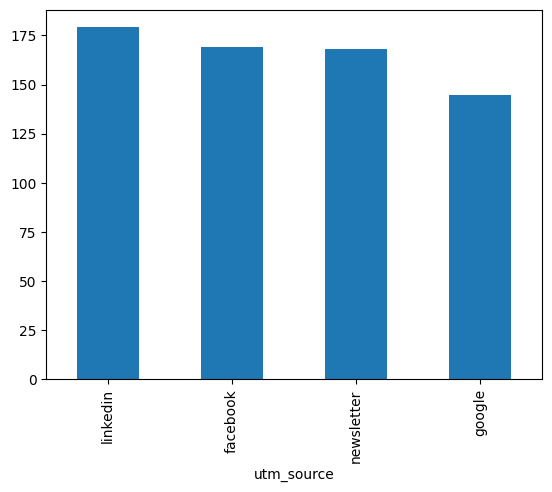

In [179]:
get_mean_by_column(web_tracking_df, "utm_source", plot=True)

Google leads to the least engagement with 179 seconds.
LinkedIn leads to the most engagement with 145 seconds.
Newsletter and Facebook lead to also rather high engagement.

In [180]:
get_mean_by_column(web_tracking_df, "utm_medium", plot=False)

utm_medium
organic     171.666667
email       169.968750
cpc         165.555556
referral    147.538462
Name: time_spent_sec, dtype: float64

<Axes: xlabel='utm_medium'>

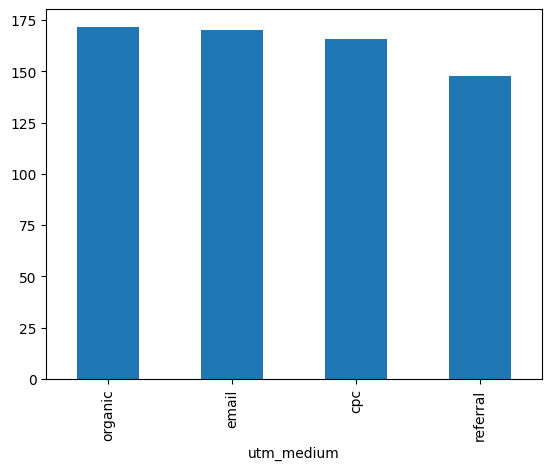

In [181]:
get_mean_by_column(web_tracking_df, "utm_medium", plot=True)

Organic, Email and CPC lead to very similar engagements.  
Does cpc not lead to higher engagement? --> check also conversion  
Referral leads to the least engagement. --> what sources are causing referral?  

In [182]:
get_mean_by_column(web_tracking_df, "device_type", plot=False)

device_type
desktop    187.111111
mobile     154.815789
tablet     144.461538
Name: time_spent_sec, dtype: float64

<Axes: xlabel='device_type'>

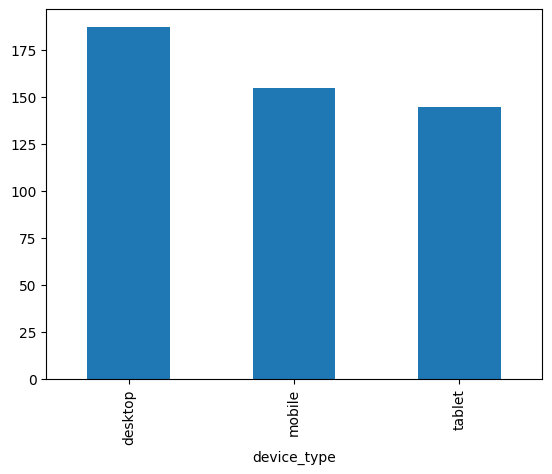

In [183]:
get_mean_by_column(web_tracking_df, "device_type", plot=True)

Desktop devices lead to higher engagement than mobile (both tablet and mobile) devices.

### Pivot Plots by Weekday

In [185]:
# Extract weekday from timestamp and create new column
web_tracking_df['weekday'] = web_tracking_df['timestamp'].dt.day_name()

In [189]:
web_tracking_df.pivot_table(index='weekday', columns="device_type", values='time_spent_sec', aggfunc='mean')

device_type,desktop,mobile,tablet
weekday,,,
Friday,172.40,152.000000,91.666667
Monday,135.75,148.600000,171.333333
Saturday,189.20,153.250000,134.333333
Sunday,217.40,150.000000,144.750000
Thursday,229.60,136.833333,149.666667
Tuesday,188.25,181.600000,149.500000
Wednesday,161.00,163.333333,159.750000


### Heat maps web tracking data

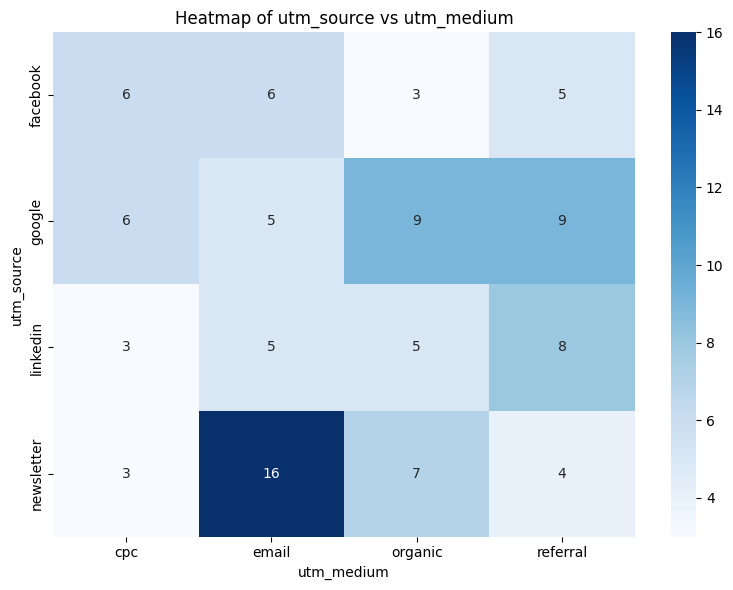

In [184]:
import seaborn as sns

utm_counts = web_tracking_df.groupby(['utm_source', 'utm_medium']).size().unstack(fill_value=0)
plt.figure(figsize=(8, 6))
sns.heatmap(utm_counts, annot=True, fmt="d", cmap="Blues")
plt.title("Heatmap of utm_source vs utm_medium")
plt.xlabel("utm_medium")
plt.ylabel("utm_source")
plt.tight_layout()
plt.savefig(os.path.join(PLOT_FOLDER, "utm_source_utm_medium_heatmap.png"), format="png")
plt.show()

## Merging CRM and Web-Tracking data

### Page visits

In [43]:
web_tracking_df.sort_values("timestamp", inplace = True)

In [44]:
web_tracking_df[web_tracking_df["user_id"] == 161]

,user_id,session_id,timestamp,page,time_spent_sec,utm_source,utm_medium,device_type
37,161,s037,2024-03-01 06:29:00,/contact,11,facebook,referral,tablet
40,161,s040,2024-03-03 18:03:00,/contact,63,facebook,email,tablet
38,161,s038,2024-03-04 18:03:00,/pricing,139,facebook,cpc,tablet
93,161,s093,2024-03-06 17:50:00,/features,63,google,referral,mobile
84,161,s084,2024-03-07 03:22:00,/features,46,google,cpc,tablet


In [ ]:
nb_of_pages_visited = web_tracking_df.user_id.value_counts()
nb_of_pages_visited_df = nb_of_pages_visited.to_frame().reset_index()
nb_of_pages_visited_df.rename(columns = {"count":"numb_pages"}, inplace = True)

In [66]:
# nb_of_pages_visited is a Series with user_id as index and visit count as value
freq_of_visit_counts = nb_of_pages_visited.value_counts()
print(freq_of_visit_counts)

count
1    33
2    21
3     4
4     2
5     1
Name: count, dtype: int64


In [49]:
def get_last_page(x):
    last_page = x.to_list()[-1]
    return last_page

In [50]:
last_page = web_tracking_df.groupby('user_id').page.apply(get_last_page)

In [51]:
last_page_df = last_page.to_frame().reset_index()
last_page_df.rename(columns = {"page":"last_page"}, inplace=True)

In [52]:
def get_first_page(x):
    first_page = x.to_list()[0]
    return first_page

In [53]:
first_page = web_tracking_df.groupby('user_id').page.apply(get_first_page)

In [54]:
first_page_df = first_page.to_frame().reset_index()
first_page_df.rename(columns = {"page":"first_page"}, inplace=True)

In [55]:
merged_df = crm_df.merge(last_page_df, on = "user_id")\
            .merge(first_page_df, on = "user_id")\
            .merge(nb_of_pages_visited_df, on = "user_id")

In [136]:
merged_df.head()

,user_id,lead_status,company,sign_up_date,industry,country,last_page,first_page,numb_pages
0,184,Prospect,Company_18,2024-03-01,Finance,US,/features,/features,1
1,163,Lost,Company_3,2024-03-01,SaaS,US,/features,/pricing,2
2,199,Converted,Company_32,2024-03-01,Healthcare,US,/landing,/features,2
3,151,Converted,Company_5,2024-03-01,Finance,US,/pricing,/pricing,1
4,191,Prospect,Company_42,2024-03-01,SaaS,Germany,/pricing,/contact,2


last_page
/pricing     57.142857
/landing     53.846154
/features    36.842105
/contact     25.000000
Name: lead_status, dtype: float64


<Axes: title={'center': 'Conversion Rate by last_page'}, xlabel='last_page', ylabel='Conversion Rate'>

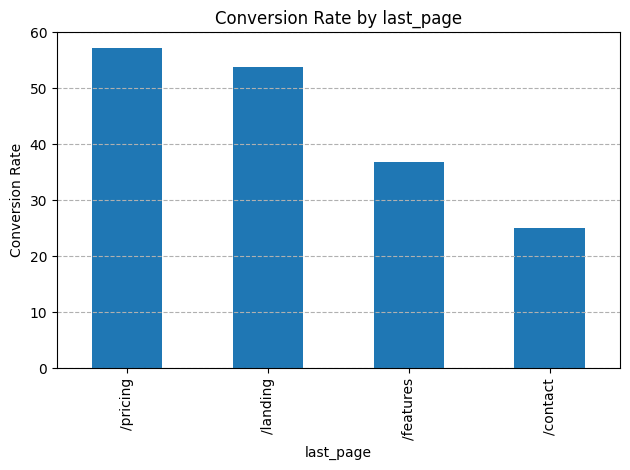

In [60]:
plot_conversion_rate_by_column(merged_df, "last_page", True,"conversion_rate_by_last_page.png")

- if a user ends on contact page he/she does not converse in 3 out of 4 cases
- if a user ends on pricing page he/she converse in 54% of the cases

first_page
/landing     63.636364
/pricing     57.142857
/features    47.058824
/contact      8.333333
Name: lead_status, dtype: float64


<Axes: title={'center': 'Conversion Rate by first_page'}, xlabel='first_page', ylabel='Conversion Rate'>

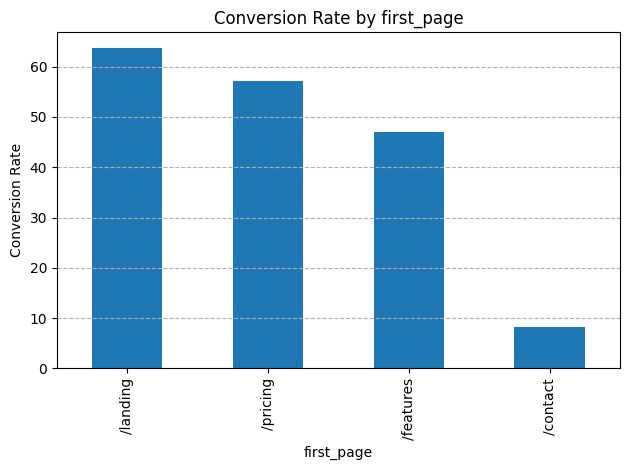

In [62]:
plot_conversion_rate_by_column(merged_df, "first_page", True,"conversion_rate_by_first_page.png")

In [63]:
merged_df.numb_pages.value_counts().to_clipboard()

numb_pages
5    100.000000
4    100.000000
1     57.894737
3     50.000000
2     50.000000
Name: lead_status, dtype: float64


<Axes: title={'center': 'Conversion Rate by numb_pages'}, xlabel='numb_pages', ylabel='Conversion Rate'>

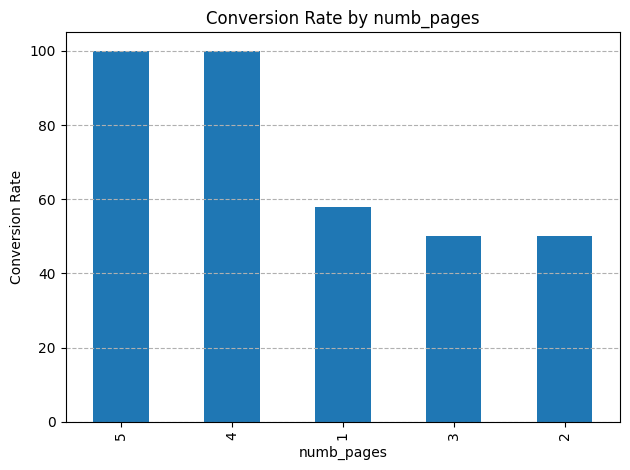

In [64]:
plot_conversion_rate_by_column(merged_df, "numb_pages", False,"conversion_rate_by_numb_page.png")

# Profiling

In [ ]:
# pandas profiling
crm_profile = ProfileReport(crm_df, 
                            title="CRM Data Profiling Report", 
                            explorative=True)
web_tracking_profile = ProfileReport(web_tracking_df, 
                                     title="Web Tracking Data Profiling Report", 
                                     explorative=True)
crm_profile.to_file("crm_data_profile.html")
web_tracking_profile.to_file("web_tracking_data_profile.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 64.10it/s]


In [ ]:
# pandas profiling
crm_profile = ProfileReport(crm_df, 
                            title="CRM Data Profiling Report", 
                            explorative=True)
web_tracking_profile = ProfileReport(web_tracking_df, 
                                     title="Web Tracking Data Profiling Report", 
                                     explorative=True)
crm_profile.to_file("crm_data_profile.html")
web_tracking_profile.to_file("web_tracking_data_profile.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 64.10it/s]
